In [1]:
import os
import pandas
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

In [2]:
class CNN_Mnist(nn.Module):
    def __init__(self):
        super(CNN_Mnist, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*7*7, 16),
            nn.ReLU(),
        )

        self.z_mean = nn.Linear(16, 2)
        self.z_log_var = nn.Linear(16, 2)

        self.decoder = nn.Sequential(
            nn.Linear(2, 64*7*7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        enc = self.encoder(x)
        mu = self.z_mean(enc)
        lv = self.z_log_var(enc)
        lat = self.reparam(mu, lv)
        dec = self.decoder(lat)
        
        return dec, mu, lv

    def reparam(self, mu, lv):
        std = torch.exp(0.5 * lv)
        eps = torch.randn_like(std)
        return mu + std * eps

In [3]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

trainset = MNIST(root='~/data', train=True, download=True, transform=transform)
train_dl = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testset = MNIST(root='~/data', train=False, download=True, transform=transform)
test_dl = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

print(len(trainset), len(testset))
print(len(train_dl), len(test_dl))

60000 10000
469 79


In [4]:
def gaussian_kls(mu, logvar):
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    return beta * torch.mean(kld_loss)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = CNN_Mnist().to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 30

beta = 0.1

kl_weight = 128/len(trainset)

recon_loss = nn.BCELoss(reduction='none')

def loss_fn(recon_x, x):
    return torch.mean(torch.sum(recon_loss(recon_x, x), dim=(1,2,3)))

In [6]:
for epoch in range(epochs):
    model.train()
    tr_total_loss = {
        "rec_loss" : 0,
        "kl_loss" : 0
    }
    for train_img, _ in tqdm(train_dl):
        train_img = train_img.to(device)

        gen_img, train_mu, train_lv = model(train_img)
        train_rec_loss = loss_fn(gen_img, train_img)
        train_kl_loss = gaussian_kls(train_mu, train_lv)
        train_loss = train_rec_loss + beta * kl_weight * train_kl_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        tr_total_loss["rec_loss"] += train_rec_loss.item()
        tr_total_loss["kl_loss"] += train_kl_loss.item()

    model.eval()
    with torch.no_grad():
        va_total_loss = {
            "rec_loss" : 0,
            "kl_loss" : 0
        }
        for valid_img, _ in tqdm(test_dl):
            valid_img = valid_img.to(device)

            gen_img, valid_mu, valid_lv = model(valid_img)
            valid_rec_loss = loss_fn(gen_img, valid_img)
            valid_kl_loss = gaussian_kls(valid_mu, valid_lv)
            valid_loss = valid_rec_loss + valid_kl_loss

            va_total_loss["rec_loss"] += valid_rec_loss.item()
            va_total_loss["kl_loss"] += valid_kl_loss.item()

    print(f"Epoch: {epoch} - TrainRecLoss: {tr_total_loss['rec_loss']/len(train_dl)} - ValidRecLoss: {va_total_loss['rec_loss']/len(test_dl)}")
    print(f"Epoch: {epoch} - TrainDivLoss: {tr_total_loss['kl_loss']/len(train_dl)} - ValidDivLoss: {va_total_loss['kl_loss']/len(test_dl)}")

100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 133.85it/s]


Epoch: 0 - TrainRecLoss: 204.6311600609883 - ValidRecLoss: 176.19954748998714
Epoch: 0 - TrainDivLoss: 9.155804435012495 - ValidDivLoss: 13.001502586316459


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 155.36it/s]


Epoch: 1 - TrainRecLoss: 172.4254544060876 - ValidRecLoss: 169.27563283413272
Epoch: 1 - TrainDivLoss: 12.020754583354698 - ValidDivLoss: 10.899656277668628


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 142.84it/s]


Epoch: 2 - TrainRecLoss: 168.0696383803638 - ValidRecLoss: 166.20467927184285
Epoch: 2 - TrainDivLoss: 10.712429582437219 - ValidDivLoss: 9.931527874137782


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 146.39it/s]


Epoch: 3 - TrainRecLoss: 165.47093486989232 - ValidRecLoss: 163.85104833675337
Epoch: 3 - TrainDivLoss: 9.808689579018143 - ValidDivLoss: 9.83987347687347


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 139.02it/s]


Epoch: 4 - TrainRecLoss: 163.09590308345966 - ValidRecLoss: 161.58878973465931
Epoch: 4 - TrainDivLoss: 9.346335010487897 - ValidDivLoss: 9.076422812063482


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 152.30it/s]


Epoch: 5 - TrainRecLoss: 160.90046955425856 - ValidRecLoss: 159.65298693693137
Epoch: 5 - TrainDivLoss: 9.078835745610153 - ValidDivLoss: 8.568143337587767


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 139.94it/s]


Epoch: 6 - TrainRecLoss: 159.18337993174472 - ValidRecLoss: 158.06832653963113
Epoch: 6 - TrainDivLoss: 8.707195268765187 - ValidDivLoss: 8.531955157654195


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 147.13it/s]


Epoch: 7 - TrainRecLoss: 157.92950273525994 - ValidRecLoss: 157.27619837507416
Epoch: 7 - TrainDivLoss: 8.42773763559012 - ValidDivLoss: 8.048918766311452


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 140.66it/s]


Epoch: 8 - TrainRecLoss: 156.86081612593074 - ValidRecLoss: 156.30410863176178
Epoch: 8 - TrainDivLoss: 8.140411516242445 - ValidDivLoss: 8.233924455280546


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 146.00it/s]


Epoch: 9 - TrainRecLoss: 156.047530119353 - ValidRecLoss: 155.17937363250346
Epoch: 9 - TrainDivLoss: 7.918929958140164 - ValidDivLoss: 7.956994974160496


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 133.63it/s]


Epoch: 10 - TrainRecLoss: 155.28149196079798 - ValidRecLoss: 154.50735686096965
Epoch: 10 - TrainDivLoss: 7.828175141104757 - ValidDivLoss: 7.940566932098775


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 146.61it/s]


Epoch: 11 - TrainRecLoss: 154.65519649286006 - ValidRecLoss: 154.15816372255736
Epoch: 11 - TrainDivLoss: 7.75041375333058 - ValidDivLoss: 7.831037581721438


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 143.65it/s]


Epoch: 12 - TrainRecLoss: 154.02391055499567 - ValidRecLoss: 153.37774368479282
Epoch: 12 - TrainDivLoss: 7.689172004585836 - ValidDivLoss: 7.668849329405193


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 137.07it/s]


Epoch: 13 - TrainRecLoss: 153.49768674805728 - ValidRecLoss: 152.99031182784069
Epoch: 13 - TrainDivLoss: 7.676488332402732 - ValidDivLoss: 7.879952575587019


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 149.09it/s]


Epoch: 14 - TrainRecLoss: 152.84323861909064 - ValidRecLoss: 153.3824771929391
Epoch: 14 - TrainDivLoss: 7.76417364799646 - ValidDivLoss: 8.031076322627973


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 142.74it/s]


Epoch: 15 - TrainRecLoss: 152.2406549514738 - ValidRecLoss: 152.24685977984078
Epoch: 15 - TrainDivLoss: 7.805198938861839 - ValidDivLoss: 8.102337970009334


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 149.90it/s]


Epoch: 16 - TrainRecLoss: 151.79884686500532 - ValidRecLoss: 151.56632821771163
Epoch: 16 - TrainDivLoss: 7.929026454242308 - ValidDivLoss: 8.231914417653144


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 142.04it/s]


Epoch: 17 - TrainRecLoss: 151.18639180197644 - ValidRecLoss: 151.06101255779024
Epoch: 17 - TrainDivLoss: 8.026480564938934 - ValidDivLoss: 7.992149491853352


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 141.05it/s]


Epoch: 18 - TrainRecLoss: 150.74468066900778 - ValidRecLoss: 150.51138054570066
Epoch: 18 - TrainDivLoss: 8.07495151247297 - ValidDivLoss: 8.308679520329342


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 142.32it/s]


Epoch: 19 - TrainRecLoss: 150.2018641815511 - ValidRecLoss: 150.14824956580054
Epoch: 19 - TrainDivLoss: 8.151517734852936 - ValidDivLoss: 8.502858421470545


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 148.71it/s]


Epoch: 20 - TrainRecLoss: 149.78638788479478 - ValidRecLoss: 149.97808625426472
Epoch: 20 - TrainDivLoss: 8.190153793993789 - ValidDivLoss: 8.427175745179381


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 150.93it/s]


Epoch: 21 - TrainRecLoss: 149.29395331604394 - ValidRecLoss: 149.68642666973645
Epoch: 21 - TrainDivLoss: 8.268991767216338 - ValidDivLoss: 8.459002748320374


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 139.31it/s]


Epoch: 22 - TrainRecLoss: 148.97754693590502 - ValidRecLoss: 148.95862646947933
Epoch: 22 - TrainDivLoss: 8.313139996803137 - ValidDivLoss: 8.501395466961439


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 148.84it/s]


Epoch: 23 - TrainRecLoss: 148.56699961843267 - ValidRecLoss: 148.9238611535181
Epoch: 23 - TrainDivLoss: 8.434248145455236 - ValidDivLoss: 8.422401265252995


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 142.48it/s]


Epoch: 24 - TrainRecLoss: 148.31751337437743 - ValidRecLoss: 148.35084707525712
Epoch: 24 - TrainDivLoss: 8.484661825175987 - ValidDivLoss: 8.34597242331203


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 136.52it/s]


Epoch: 25 - TrainRecLoss: 147.9664940091847 - ValidRecLoss: 148.29243585127819
Epoch: 25 - TrainDivLoss: 8.559076027575331 - ValidDivLoss: 8.637412427346918


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 147.93it/s]


Epoch: 26 - TrainRecLoss: 147.704169169672 - ValidRecLoss: 147.9264037699639
Epoch: 26 - TrainDivLoss: 8.629217312534227 - ValidDivLoss: 8.701071793519997


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 141.05it/s]


Epoch: 27 - TrainRecLoss: 147.52507988577966 - ValidRecLoss: 148.14147331141217
Epoch: 27 - TrainDivLoss: 8.657100030862447 - ValidDivLoss: 8.519742947590503


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 149.46it/s]


Epoch: 28 - TrainRecLoss: 147.0912988007958 - ValidRecLoss: 147.40289171436166
Epoch: 28 - TrainDivLoss: 8.736260347020652 - ValidDivLoss: 8.853287696838379


100%|██████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 150.31it/s]

Epoch: 29 - TrainRecLoss: 146.92023189845625 - ValidRecLoss: 147.68486138838756
Epoch: 29 - TrainDivLoss: 8.850249361636033 - ValidDivLoss: 8.808429090282585


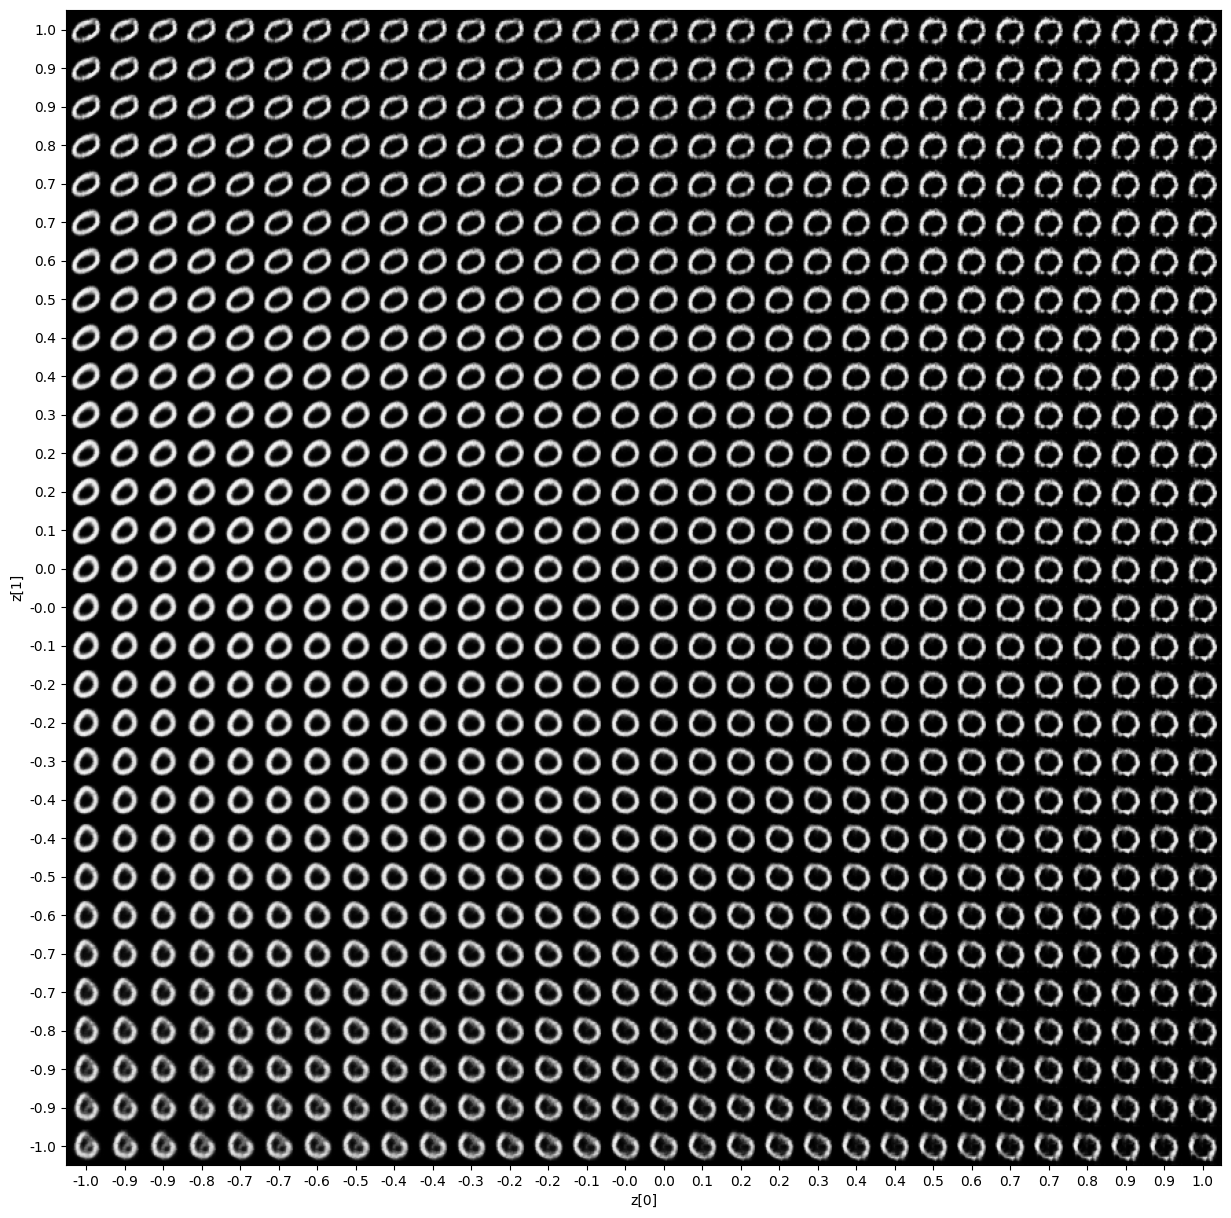

In [7]:
digit_size = 28
scale = 1.0
n = 30
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-scale, scale, n)
grid_y = np.linspace(-scale, scale, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = torch.tensor([[xi, yi]]).to(device, dtype=torch.float)
        x_decoded = model.decoder(z_sample)
        digit = x_decoded[0].detach().cpu().numpy()
        figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size,
        ] = digit

plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x) 
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure, cmap="Greys_r")
plt.show()